# Using and Understanding Docling for Targeted Geofenced Extraction on Documents

## The `document_to_extraction.py` script

This is designed as a .py script to be run in CLI, not as a notebook. If you want to run it, copy the code out of this and create a .py file.

IMPORTANT NOTE--This has the Docling package internal DEBUG settings for vizualizing OCR/Table/Layout etc. image creation active, which is highlight commented in the .py code. If you want to vizualize the outputs for the documts, it will dump those images into a `./debug/` folder in `cwd`. If you're running this on a lot of documents, that folder can blow up in disk space. ***CAREFUL***

### Basic Usage
`python document_to_extraction.py INPUT_DIRECTORY [--output_dir OUTPUT_DIRECTORY] [--log-level LEVEL]`

### Required Arguments

`INPUT_DIRECTORY`: The directory containing your documents to process

- Supports files with extensions: .pdf, .png, .jpg, .jpeg, .tiff, .tif
- This argument is mandatory and must be provided

### Optional Arguments
#### Output Directory

`--output_dir OUTPUT_DIRECTORY`

Specifies where processed files will be saved. Defaults to "scratch/" if not provided. The directory will be created if it doesn't exist. For each input file, creates three output files:

- `{filename}.md`: Markdown version
- `{filename}.json`: JSON format
- `{filename}.yaml`: YAML format

#### Logging Level

`--log-level LEVEL`

Controls the verbosity of logging output
Available options: DEBUG, INFO, WARNING, ERROR
Defaults to "INFO" if not specified
Use DEBUG for maximum detail during troubleshooting

#### Example Commands
Process files in the "documents" folder using default settings:
- `python document_to_extraction.py documents`

Process files with custom output location:
- `python document_to_extraction.py documents --output_dir processed_files`

Process files with detailed debug logging:
- `python document_to_extraction.py documents --log-level DEBUG`

```python
import argparse
import json
import logging
from pathlib import Path
from typing import List

import yaml
from docling.backend.pypdfium2_backend import PyPdfiumDocumentBackend
from docling.datamodel.base_models import InputFormat
from docling.datamodel.settings import settings
from docling.document_converter import (
    DocumentConverter,
    PdfFormatOption,
    WordFormatOption,
)
from docling.pipeline.simple_pipeline import SimplePipeline
from docling.pipeline.standard_pdf_pipeline import StandardPdfPipeline

_log = logging.getLogger(__name__)

"""
This section immediately below is uncommments, and created a debug folder in cwd
that produces debug images of the extractions. That includes the OCR bounding boxes
"""
# Turn on inline debug visualizations:
settings.debug.visualize_layout = True
settings.debug.visualize_ocr = True
settings.debug.visualize_tables = True
settings.debug.visualize_cells = True


def get_input_files(input_dir: Path) -> List[Path]:
    """Get all PDF and image files from the input directory."""
    supported_extensions = {".pdf", ".png", ".jpg", ".jpeg", ".tiff", ".tif"}
    return [
        Path(f) for f in input_dir.iterdir() if f.suffix.lower() in supported_extensions
    ]


def main(input_dir, output_dir):
    doc_converter = (
        DocumentConverter(  # all of the below is optional, has internal defaults.
            allowed_formats=[
                InputFormat.PDF,
                InputFormat.IMAGE,
                InputFormat.DOCX,
                InputFormat.HTML,
                InputFormat.PPTX,
                InputFormat.ASCIIDOC,
                InputFormat.MD,
            ],  # whitelist formats, non-matching files are ignored.
            format_options={
                InputFormat.PDF: PdfFormatOption(
                    pipeline_cls=StandardPdfPipeline, backend=PyPdfiumDocumentBackend
                ),
                InputFormat.DOCX: WordFormatOption(
                    pipeline_cls=SimplePipeline  # , backend=MsWordDocumentBackend
                ),
            },
        )
    )

    conv_results = doc_converter.convert_all(get_input_files(input_dir))

    for res in conv_results:
        out_path = output_dir
        print(
            f"Document {res.input.file.name} converted."
            f"\nSaved markdown output to: {str(out_path)}"
        )
        _log.debug(res.document._export_to_indented_text(max_text_len=16))
        # Export Docling document format to markdowndoc:
        with (out_path / f"{res.input.file.stem}.md").open("w") as fp:
            fp.write(res.document.export_to_markdown())

        with (out_path / f"{res.input.file.stem}.json").open("w") as fp:
            fp.write(json.dumps(res.document.export_to_dict()))

        with (out_path / f"{res.input.file.stem}.yaml").open("w") as fp:
            fp.write(yaml.safe_dump(res.document.export_to_dict()))


if __name__ == "__main__":
    # Set up argument parser
    parser = argparse.ArgumentParser(description="Process documents with Docling")
    parser.add_argument(
        "input_dir", type=str, help="Input directory containing documents"
    )
    parser.add_argument(
        "--output_dir",
        type=str,
        default="scratch/",
        help="Output directory for processed files (default: scratch/)",
    )
    parser.add_argument(
        "--log-level",
        type=str,
        default="INFO",
        choices=["DEBUG", "INFO", "WARNING", "ERROR"],
        help="Set the logging level",
    )

    args = parser.parse_args()

    # Set up logging
    logging.basicConfig(
        level=getattr(logging, args.log_level),
        format="%(asctime)s - %(levelname)s - %(message)s",
    )

    # Convert string paths to Path objects
    input_dir = Path(args.input_dir)
    output_dir = Path(args.output_dir)

    # Validate input directory
    if not input_dir.exists():
        raise ValueError(f"Input directory does not exist: {input_dir}")

    # Create output directory
    output_dir.mkdir(parents=True, exist_ok=True)

    main(input_dir, output_dir)
```

## Examing the Docling Document Object and How to Use it

In [1]:
from docling_core.types.doc import DoclingDocument
import copy
import json
from pathlib import Path
from pprint import pprint
from thefuzz import fuzz
from PIL import Image
from IPython.display import display

**I pulled this image from Google Images for testing, but I'm not sure if the information is actually true or not, so I redacted what might be personal info, not sure**

In [2]:
# Load saved docling doc from disk:
with Path("/home/joe/ttop/nlp_proj/docling/scratch/large.json").open("r") as fp:
    doc_dict = json.loads(fp.read())
    doc = DoclingDocument.model_validate(
        doc_dict
    )  # use standard pydantic API to populate doc

**Let's see the actual image of the form**

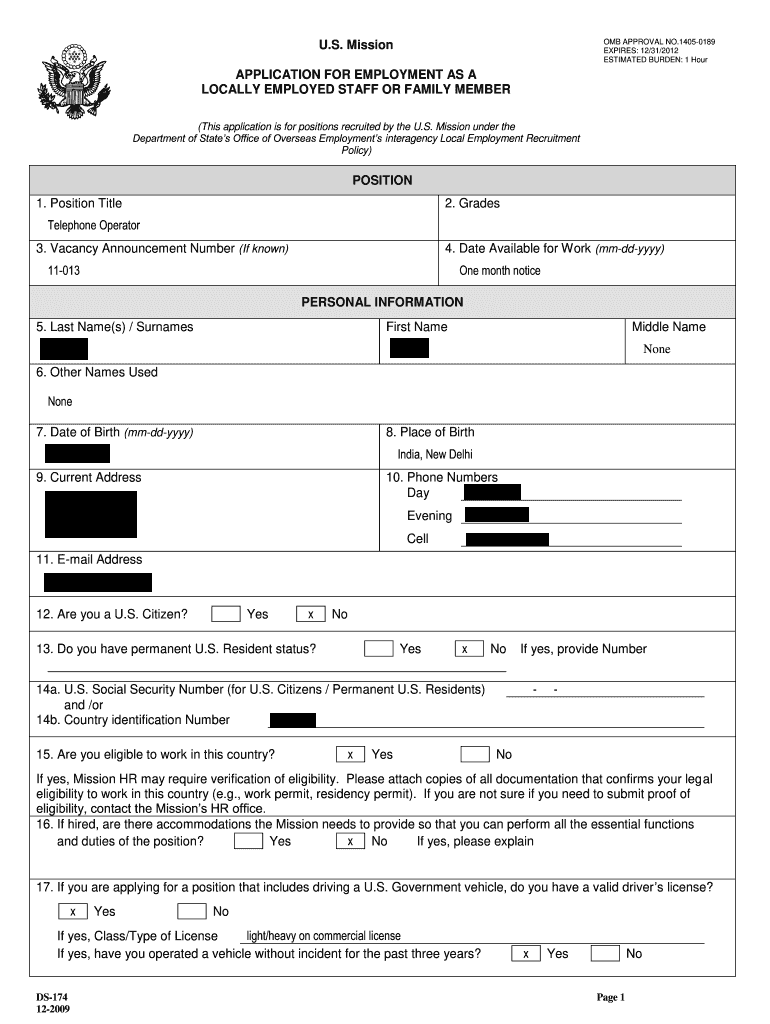

In [3]:
# Load image from disk:
img_path = Path("/home/joe/ttop/nlp_proj/data/forms/large.png")
img = img_path.read_bytes()
# Display image:
display(Image.open(img_path))

**This is an example of the OCR output from Docling**

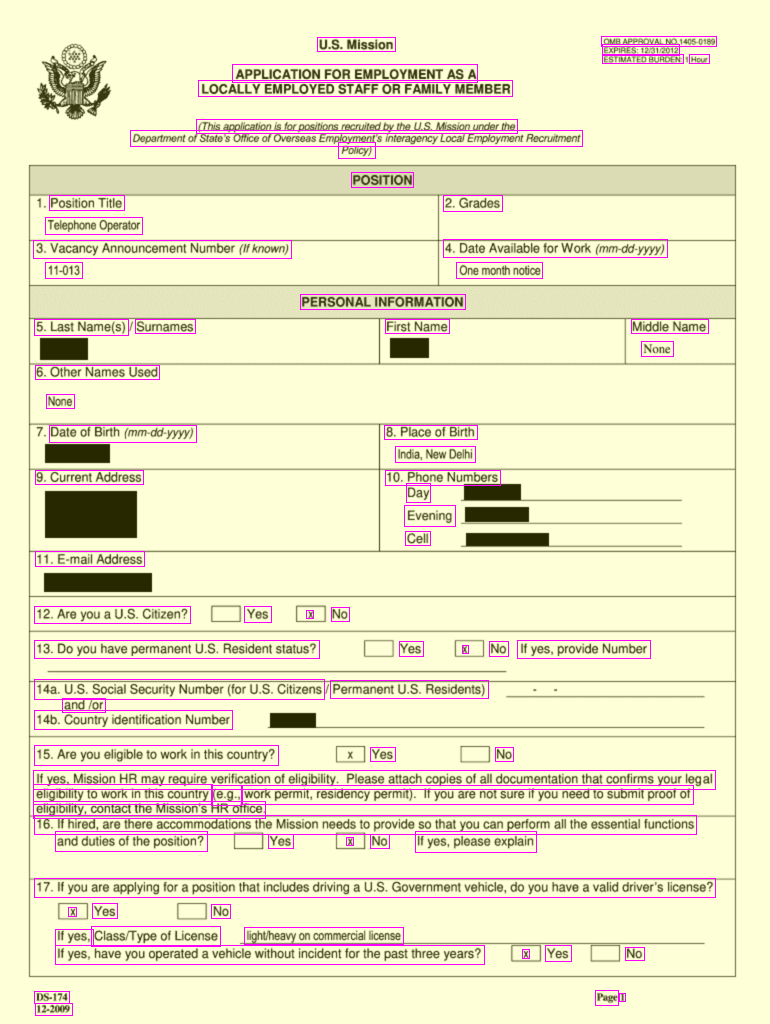

In [4]:
# Load image from disk:
ocr_img_path = Path(
    "/home/joe/ttop/nlp_proj/docling/debug/debug_large/ocr_page_00000.png"
)
img = img_path.read_bytes()
# Display image:
display(Image.open(ocr_img_path))

## Docling Document Object in it's Entirety

### The major parts of a Docling Document object
[Docling Document Documentation](https://ds4sd.github.io/docling/reference/docling_document/)
- body
- furniture
- groups
- key_value_items
- name
- origin
- pages
- pictures
- schema_name
- tables
- texts
- version

In [5]:
doc

DoclingDocument(schema_name='DoclingDocument', version='1.0.0', name='large', origin=DocumentOrigin(mimetype='application/pdf', binary_hash=17442536969041507999, filename='large.png', uri=None), furniture=GroupItem(self_ref='#/furniture', parent=None, children=[], name='_root_', label=<GroupLabel.UNSPECIFIED: 'unspecified'>), body=GroupItem(self_ref='#/body', parent=None, children=[RefItem(cref='#/pictures/0'), RefItem(cref='#/groups/0'), RefItem(cref='#/texts/2'), RefItem(cref='#/groups/1'), RefItem(cref='#/texts/5'), RefItem(cref='#/texts/6'), RefItem(cref='#/groups/2'), RefItem(cref='#/texts/8'), RefItem(cref='#/texts/9'), RefItem(cref='#/pictures/1'), RefItem(cref='#/texts/10'), RefItem(cref='#/groups/3'), RefItem(cref='#/texts/12'), RefItem(cref='#/groups/4'), RefItem(cref='#/texts/17'), RefItem(cref='#/texts/18'), RefItem(cref='#/texts/19'), RefItem(cref='#/texts/20'), RefItem(cref='#/groups/5'), RefItem(cref='#/texts/23'), RefItem(cref='#/texts/24'), RefItem(cref='#/groups/6'), 

In [6]:
pprint(doc.dict())

{'body': {'children': [{'cref': '#/pictures/0'},
                       {'cref': '#/groups/0'},
                       {'cref': '#/texts/2'},
                       {'cref': '#/groups/1'},
                       {'cref': '#/texts/5'},
                       {'cref': '#/texts/6'},
                       {'cref': '#/groups/2'},
                       {'cref': '#/texts/8'},
                       {'cref': '#/texts/9'},
                       {'cref': '#/pictures/1'},
                       {'cref': '#/texts/10'},
                       {'cref': '#/groups/3'},
                       {'cref': '#/texts/12'},
                       {'cref': '#/groups/4'},
                       {'cref': '#/texts/17'},
                       {'cref': '#/texts/18'},
                       {'cref': '#/texts/19'},
                       {'cref': '#/texts/20'},
                       {'cref': '#/groups/5'},
                       {'cref': '#/texts/23'},
                       {'cref': '#/texts/24'},
              

### Docling Text Examples

In [7]:
for text in doc.texts[:5]:
    pprint(text)
pprint(doc_dict["texts"][0])

ListItem(self_ref='#/texts/0', parent=RefItem(cref='#/groups/0'), children=[], label=<DocItemLabel.LIST_ITEM: 'list_item'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=36.17273712158203, t=828.3333129882812, r=124.0, b=813.6666870117188, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 14))], orig='Position Title', text='Position Title', enumerated=False, marker='-')
ListItem(self_ref='#/texts/1', parent=RefItem(cref='#/groups/0'), children=[], label=<DocItemLabel.LIST_ITEM: 'list_item'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=443.3333435058594, t=829.0, r=502.3333435058594, b=812.3333129882812, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 9))], orig='2. Grades', text='2. Grades', enumerated=False, marker='-')
TextItem(self_ref='#/texts/2', parent=RefItem(cref='#/body'), children=[], label=<DocItemLabel.TEXT: 'text'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=45.66666793823242, t=806.3333129882812, r=142.6666717529297,

### Docling Text Object Examples and Explanations

So a single example of the actual `Docling.text[0]` object looks like...

```python
ListItem(self_ref='#/texts/0', parent=RefItem(cref='#/groups/0'), children=[], label=<DocItemLabel.LIST_ITEM: 'list_item'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=36.17273712158203, t=828.3333129882812, r=124.0, b=813.6666870117188, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 14))], orig='Position Title', text='Position Title', enumerated=False, marker='-')
```

Which, to make it a bit easier to understand via a hiearchical pprint of a dictionary structure ```doc_dict["texts"][0]``` looks like...
```JSON
{'children': [],
 'enumerated': False,
 'label': 'list_item',
 'marker': '-',
 'orig': 'Position Title',
 'parent': {'$ref': '#/groups/0'},
 'prov': [{'bbox': {'b': 813.6666870117188,
                    'coord_origin': 'BOTTOMLEFT',
                    'l': 36.17273712158203,
                    'r': 124.0,
                    't': 828.3333129882812},
           'charspan': [0, 14],
           'page_no': 1}],
 'self_ref': '#/texts/0',
 'text': 'Position Title'}
 ```

#### Basic Properties
- `children`: An empty array (`[]`) indicating this item has no child elements
- `enumerated`: Boolean value (`False`) indicating this is not an enumerated/numbered list item
- `label`: String value (`'list_item'`) identifying this as a list item element
- `marker`: String value (`'-'`) specifying the bullet point style used for this list item
- `orig`: String value (`'Position Title'`) containing the original text content
- `text`: String value (`'Position Title'`) containing the processed/final text content

#### References and Relationships
- `parent`: Reference object (`{'$ref': '#/groups/0'}`) pointing to the parent group (likely a list container)
- `self_ref`: String value (`'#/texts/0'`) providing a unique reference to this text element

#### Provenance Information
The `prov` array contains document positioning and origin information:

##### Bounding Box (`bbox`)
- `b` (bottom): 813.6666870117188
- `l` (left): 36.17273712158203
- `r` (right): 124.0
- `t` (top): 828.3333129882812
- `coord_origin`: 'BOTTOMLEFT' (indicating coordinate system originates from bottom-left)

##### Text Position
- `charspan`: Array `[0, 14]` indicating this text spans characters 0 through 14
- `page_no`: Integer value `1` indicating this appears on page 1

##### Usage Notes
- The coordinate system uses BOTTOMLEFT origin, meaning Y-coordinates increase going up the page
- The bounding box height can be calculated as `t - b` (approximately 15 units)
- This appears to be a list item from a bulleted list, specifically the first text element in the document (based on `self_ref`)

In [8]:
doc.texts[0]

ListItem(self_ref='#/texts/0', parent=RefItem(cref='#/groups/0'), children=[], label=<DocItemLabel.LIST_ITEM: 'list_item'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=36.17273712158203, t=828.3333129882812, r=124.0, b=813.6666870117188, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 14))], orig='Position Title', text='Position Title', enumerated=False, marker='-')

As far as I've seen, prov is a list that is always len() == 1, so we can just use [0] to get the first element, which encodes all the information needed to get the bounding information.

For non-text items, this might get more complicated, but at least for this use case, it seems to work. The items for a 

In [9]:
print(doc.texts[0].prov)
pprint(doc.texts[0].prov[0].dict())

[ProvenanceItem(page_no=1, bbox=BoundingBox(l=36.17273712158203, t=828.3333129882812, r=124.0, b=813.6666870117188, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 14))]
{'bbox': {'b': 813.6666870117188,
          'coord_origin': <CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>,
          'l': 36.17273712158203,
          'r': 124.0,
          't': 828.3333129882812},
 'charspan': (0, 14),
 'page_no': 1}


In [10]:
doc.texts[0].prov[0]

ProvenanceItem(page_no=1, bbox=BoundingBox(l=36.17273712158203, t=828.3333129882812, r=124.0, b=813.6666870117188, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 14))

In [11]:
# use a list comprehension to find the text 'Position Title' with a fuzzy match in doc.texts.
THRESHOLD = 80
found_text = [
    text
    for text in doc.texts
    if fuzz.partial_ratio("Position Title", text.text) > THRESHOLD
]
print(f"Found {len(found_text)} matches")
print("==========The Found Text==========")
pprint(found_text[0].text)
print()
print("==========The Found Text Object Heiarchicah JSON==========")
pprint(found_text[0].dict())
print()
print("==========The Found Text Object Bounding Boxes==========")
pprint(found_text[0].prov[0].bbox.dict())

Found 1 matches
==========The Found Text==========
'Position Title'

==========The Found Text Object Heiarchicah JSON==========
{'children': [],
 'enumerated': False,
 'label': <DocItemLabel.LIST_ITEM: 'list_item'>,
 'marker': '-',
 'orig': 'Position Title',
 'parent': {'cref': '#/groups/0'},
 'prov': [{'bbox': {'b': 813.6666870117188,
                    'coord_origin': <CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>,
                    'l': 36.17273712158203,
                    'r': 124.0,
                    't': 828.3333129882812},
           'charspan': (0, 14),
           'page_no': 1}],
 'self_ref': '#/texts/0',
 'text': 'Position Title'}

==========The Found Text Object Bounding Boxes==========
{'b': 813.6666870117188,
 'coord_origin': <CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>,
 'l': 36.17273712158203,
 'r': 124.0,
 't': 828.3333129882812}


In [12]:
# Let's pull out some repeated functions in this process
def find_text_bbox(search_text, doc):
    THRESHOLD = 80
    found_text = [
        text
        for text in doc.texts
        if fuzz.partial_ratio(search_text, text.text) > THRESHOLD
    ]
    if not found_text:
        return None
    return found_text


def found_text_debug(found_text, img_height, img_width):
    # Debugging Infomation
    print(f"Found {len(found_text)} matches")
    print("==========The Found Text==========")
    pprint(found_text[0].text)
    print()
    print("==========The Found Text Object Heiarchicah JSON==========")
    pprint(found_text[0].model_dump())
    print()
    print("==========The Found Text Object Bounding Boxes==========")
    pprint(f"Image Height: {img_height}")
    pprint(f"Image Width: {img_width}")
    pprint(found_text[0].prov[0].bbox.model_dump())


def convert_bottomleft_to_topleft(bbox, img_height):
    # Convert coordinates from BOTTOMLEFT to TOPLEFT
    left = bbox.l
    right = bbox.r
    top = bbox.t
    bottom = bbox.b
    return left, top, right, bottom


def crop_and_resize(img, left, top, right, bottom, img_height, img_width):
    # Crop image using converted coordinates
    cropped_img = img.crop((left, top, right, bottom))

    # Calculate new height maintaining aspect ratio
    target_width = 400
    width_percent = target_width / float(cropped_img.size[0])
    target_height = int((float(cropped_img.size[1]) * float(width_percent)))

    # Resize image
    resized_img = cropped_img.resize(
        (target_width, target_height), Image.Resampling.LANCZOS
    )
    return resized_img

### Weird Issue I don't fully understand yet with Coordinate System
The default for Docling coordinate system is TOPLEFT, which is what alost everything else uses, but the file output this time was bottom left. The BoundingBox class has a conversion ability as a method within it, so this function below creates a copy of the document class and converts everything to TOPLEFT coordinate system from BOTTOMLEFT. I don't know why this happened and I can't find the reason in the documentation. If this happens to you, this code will convert EVERYTHING in the Docling Document Class to TOPLEFT coordinate system.

In [13]:
def flip_doc_y_axis(doc):
    # Create a deep copy to avoid modifying the original
    alt_doc = copy.deepcopy(doc)

    def convert_provs(item, page_heights):
        """Helper to convert all provenances for an item"""
        if hasattr(item, "prov"):
            for prov in item.prov:
                page_height = page_heights.get(prov.page_no)
                if page_height is not None:
                    prov.bbox = prov.bbox.to_top_left_origin(page_height)

    # Get all page heights once
    page_heights = {
        page_no: page.size.height for page_no, page in alt_doc.pages.items()
    }

    # Convert coordinates in all document elements
    for text in alt_doc.texts:
        convert_provs(text, page_heights)

    for picture in alt_doc.pictures:
        convert_provs(picture, page_heights)

    for table in alt_doc.tables:
        convert_provs(table, page_heights)
        # Also convert table cell bounding boxes
        for cell in table.data.table_cells:
            if cell.bbox is not None:
                # Use the table's first provenance page height for cells
                if len(table.prov) > 0:
                    page_height = page_heights.get(table.prov[0].page_no)
                    if page_height is not None:
                        cell.bbox = cell.bbox.to_top_left_origin(page_height)

    for group in alt_doc.groups:
        convert_provs(group, page_heights)

    return alt_doc


flip_doc = flip_doc_y_axis(doc)

In [14]:
# We have to flip the y-axis for the bounding box coordinates just to maintian consistency with the image coordinates
# Pillow uses the top-left corner as the origin, while the OCR coordinates use the bottom-left corner as the origin
flip_doc = flip_doc_y_axis(doc)

In [15]:
"""Function to visualize bounding boxes of found text overlayed on cropped image"""


def crop_and_display(search_text, doc, img_path):
    found_text = find_text_bbox(search_text, doc)
    # Open image
    img = Image.open(img_path)
    img_height = img.height
    img_width = img.width
    found_text_debug(found_text, img_height, img_width)

    # Get bounding box from first match
    bbox = found_text[0].prov[0].bbox

    # Convert coordinates from BOTTOMLEFT to TOPLEFT
    left, top, right, bottom = convert_bottomleft_to_topleft(bbox, img_height)
    resized_img = crop_and_resize(img, left, top, right, bottom, img_height, img_width)

    return resized_img

Found 1 matches
==========The Found Text==========
'Position Title'

==========The Found Text Object Heiarchicah JSON==========
{'children': [],
 'enumerated': False,
 'label': <DocItemLabel.LIST_ITEM: 'list_item'>,
 'marker': '-',
 'orig': 'Position Title',
 'parent': {'cref': '#/groups/0'},
 'prov': [{'bbox': {'b': 210.33331298828125,
                    'coord_origin': <CoordOrigin.TOPLEFT: 'TOPLEFT'>,
                    'l': 36.17273712158203,
                    'r': 124.0,
                    't': 195.66668701171875},
           'charspan': (0, 14),
           'page_no': 1}],
 'self_ref': '#/texts/0',
 'text': 'Position Title'}

==========The Found Text Object Bounding Boxes==========
'Image Height: 1024'
'Image Width: 770'
{'b': 210.33331298828125,
 'coord_origin': <CoordOrigin.TOPLEFT: 'TOPLEFT'>,
 'l': 36.17273712158203,
 'r': 124.0,
 't': 195.66668701171875}


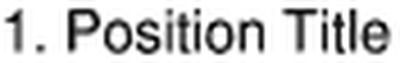

In [16]:
# Display the resized image
display(crop_and_display("Position Title", flip_doc, img_path))

Found 1 matches
==========The Found Text==========
'If yes, Class Type of License'

==========The Found Text Object Heiarchicah JSON==========
{'children': [],
 'label': <DocItemLabel.TEXT: 'text'>,
 'orig': 'If yes, Class Type of License',
 'parent': {'cref': '#/body'},
 'prov': [{'bbox': {'b': 946.6666641235352,
                    'coord_origin': <CoordOrigin.TOPLEFT: 'TOPLEFT'>,
                    'l': 55.33333206176758,
                    'r': 220.0,
                    't': 926.3333358764648},
           'charspan': (0, 29),
           'page_no': 1}],
 'self_ref': '#/texts/44',
 'text': 'If yes, Class Type of License'}

==========The Found Text Object Bounding Boxes==========
'Image Height: 1024'
'Image Width: 770'
{'b': 946.6666641235352,
 'coord_origin': <CoordOrigin.TOPLEFT: 'TOPLEFT'>,
 'l': 55.33333206176758,
 'r': 220.0,
 't': 926.3333358764648}


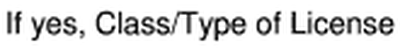

In [17]:
display(crop_and_display("If yes Class/Type of License", flip_doc, img_path))

## Why is this Useful?
In the context of a form, we can use the fuzzy-match search strings across a wide array of different image sizes, form types to localize form responses assuming the form itself is standardized.

System Setup Needs:
- Identify the items you need to extract from a form
- Do some reading and experimentation on finding the strings that are associated with the form box you need to extract info from
- For example--Let's say we want to extract the Position Title everyone applied for in 10,000 documents.
- The "Position Title" applied for is below the string "Position Title"
- We need to crop the text from the document based on position information.

Let's construct the bounding box to get that info.

In [18]:
"""Function to visualize bounding boxes of found text overlayed on cropped image"""


def crop_and_display_position_title(
    search_text, doc, img_path, right_adjust=100, bottom_adjust=35
):
    # Now we adjust the bounding box to include below the found text
    found_text = find_text_bbox(search_text, doc)
    # Open image
    img = Image.open(img_path)
    img_height = img.height
    img_width = img.width

    # Get bounding box from first match
    bbox = found_text[0].prov[0].bbox

    # Convert coordinates from BOTTOMLEFT to TOPLEFT
    left = bbox.l
    right = bbox.r + right_adjust  # Adjust right to include the text if it overflows
    top = bbox.t
    bottom = bbox.b + bottom_adjust  # Adjust bottom to include the text below

    resized_img = crop_and_resize(img, left, top, right, bottom, img_height, img_width)
    return resized_img

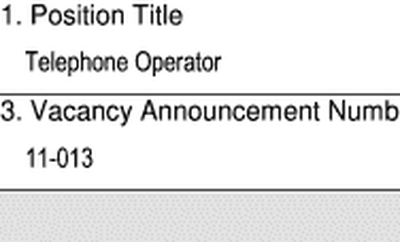

In [19]:
# right adjust looks decent, bottom adjust is too much, we iterate to find the best value
display(
    crop_and_display_position_title(
        "Position Title", flip_doc, img_path, right_adjust=100, bottom_adjust=100
    )
)

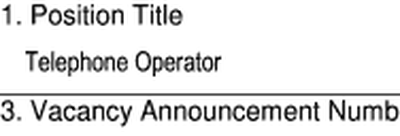

In [20]:
# Still no good, we try a smaller bottom adjust
display(
    crop_and_display_position_title(
        "Position Title", flip_doc, img_path, right_adjust=100, bottom_adjust=50
    )
)

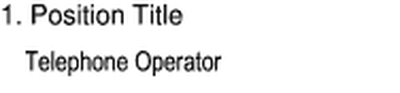

In [21]:
# Perfection
display(
    crop_and_display_position_title(
        "Position Title", flip_doc, img_path, right_adjust=100, bottom_adjust=30
    )
)

## So We Have a Bounding Box that Encapsulates a Form Response We Want, Now what?
We need that response, and that response only, so let's pull only the text that is below our searched text, but above the bottom and right side of our bounding box.

In [22]:
from docling_core.types.doc import BoundingBox, CoordOrigin

In [23]:
"""Function to visualize bounding boxes of found text overlayed on cropped image"""


def crop_and_display_position_title_return_response_text(
    search_text, doc, img_path, right_adjust=100, bottom_adjust=35
):
    # Now we adjust the bounding box to include below the found text
    found_text = find_text_bbox(search_text, doc)

    # Open image
    img = Image.open(img_path)
    img_height = img.height
    img_width = img.width

    # Get bounding box from first match
    bbox = found_text[0].prov[0].bbox

    # Cut the bounding box of the found text from the total bounding box area
    # This is to get the text below the found text
    combined_bbox = BoundingBox(
        l=bbox.l,
        t=bbox.b,
        r=bbox.r + right_adjust,
        b=bbox.b + bottom_adjust,
        origin=CoordOrigin.TOPLEFT,
    )
    print(combined_bbox)
    resized_img = crop_and_resize(
        img,
        combined_bbox.l,
        combined_bbox.t,
        combined_bbox.r,
        combined_bbox.b,
        img_height,
        img_width,
    )

    # Pull the text from the document that fits within the adapted rt_bounding_box
    # We only check if the prov is same page as searched text to limit search space
    # List comprehension for speed
    response_text = [
        text
        for text in doc.texts
        if (
            found_text[0].prov[0].page_no == text.prov[0].page_no
            and text.prov[0].bbox.l >= combined_bbox.l
            and text.prov[0].bbox.r <= combined_bbox.r
            and text.prov[0].bbox.t >= combined_bbox.t
            and text.prov[0].bbox.b <= combined_bbox.b
        )
    ]

    return resized_img, response_text


l=36.17273712158203 t=210.33331298828125 r=224.0 b=240.33331298828125 coord_origin=<CoordOrigin.TOPLEFT: 'TOPLEFT'>


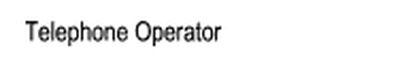

'Telephone Operator'


Found 1 matches
==========The Found Text==========
'Position Title'

==========The Found Text Object Heiarchicah JSON==========
{'children': [],
 'enumerated': False,
 'label': <DocItemLabel.LIST_ITEM: 'list_item'>,
 'marker': '-',
 'orig': 'Position Title',
 'parent': {'cref': '#/groups/0'},
 'prov': [{'bbox': {'b': 210.33331298828125,
                    'coord_origin': <CoordOrigin.TOPLEFT: 'TOPLEFT'>,
                    'l': 36.17273712158203,
                    'r': 124.0,
                    't': 195.66668701171875},
           'charspan': (0, 14),
           'page_no': 1}],
 'self_ref': '#/texts/0',
 'text': 'Position Title'}

==========The Found Text Object Bounding Boxes==========
'Image Height: 1024'
'Image Width: 770'
{'b': 210.33331298828125,
 'coord_origin': <CoordOrigin.TOPLEFT: 'TOPLEFT'>,
 'l': 36.17273712158203,
 'r': 124.0,
 't': 195.66668701171875}


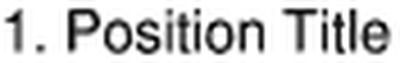

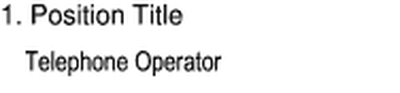

l=36.17273712158203 t=210.33331298828125 r=224.0 b=240.33331298828125 coord_origin=<CoordOrigin.TOPLEFT: 'TOPLEFT'>


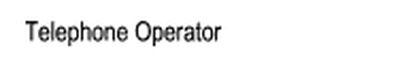

'Telephone Operator'


In [28]:
display(crop_and_display("Position Title", flip_doc, img_path))
display(
    crop_and_display_position_title(
        "Position Title", flip_doc, img_path, right_adjust=100, bottom_adjust=30
    )
)

rt_image, rt_text = crop_and_display_position_title_return_response_text(
    "Position Title", flip_doc, img_path, right_adjust=100, bottom_adjust=30
)
display(rt_image)
for text in rt_text:
    pprint(text.text)

## Success!
We found the text we needed based of a geolocaton of the form box title text, and were able to make a dynamically adjusted text extraction of the form box entry "Telephone Operator" as a string. Now all we have to do is pipe this process into some storage system that tracks the extraction from each document with it's associated meta-data. This would be a job for a SQL database, but we'll leave that for a different day.